<a href="https://colab.research.google.com/github/Bagrata1/hepatitisLOS/blob/main/DAnalytics_project_hepatitis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing packages

In [ ]:
#@title
#
from google.colab import drive
drive.mount('/content/drive')

# importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.datasets import make_regression
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn import tree, svm
from sklearn.metrics import accuracy_score
warnings.filterwarnings("ignore")


Mounted at /content/drive


# Data Analytics Project

### *Group members:*

*   Irakli Bagratishvili(0588861)
*   Esteban René Montandon Pena(0587920)
*   Malavika Parthasarathi(0586539)

## Introduction 
### Goal of the research:
>The aim of this project is to predict the length of stay of a patients at the time of arrival. Considering large number of different diagnoses available in the MIMIC database. We decided to focus on a specific sample of patients diagnosed with any type of hepatitis. 

### Clinical relevance of the research:
>The length of stay (LOS) is an important indicator of the efficiency of hospital management. Reduction in the number of inpatient days results in decreased risk of infection and medication side effects, improvement in the quality of treatment, and increased hospital profit with more efficient bed management.

### Applied methods and materials:
>We will apply a machine learning technique to build a predictive model in order to provide an accurate estimation of the length of stay of a patient.
We will implement a Python based tool using relevant libraries like scikit-learn or pandas for this
purpose.

# Regression Methods

## Acquiring and storing the data set




To build our dataset, we first selected all patients which were diagnosed with some type of hepatitis (relevant hepatitis [codes](https://www.fortherecordmag.com/archives/013012p27.shtml)). The patient data considered for this project can be devided in two types, first the patient personal data like age, gender, previous stays in the hospital, and insurance type. The second type of information is related to medical metrics like o2 saturation, heart rate, temperature measured at the arrival. These measurements are selected and summarized via descriptive statistical aggregation functions from the chartevents table. We have only considered the events registered within the first 3 hours of the patient's arrival at the hospital. 

The table below shows the events recorded with the highest number of occurrences in the first 3 hours after arrival. For this project we have selected the health metrics with the highest amount of occurrences directly related with the patients health state, rather than with their social information like "language" or "religion".

The events with the highest number of occurrences in the first three hours after arrival are listed in the table below. For out dataset, we chose health metrics with the highest number of observations directly related to the patients' health state, rather than social information like "language" or "religion".

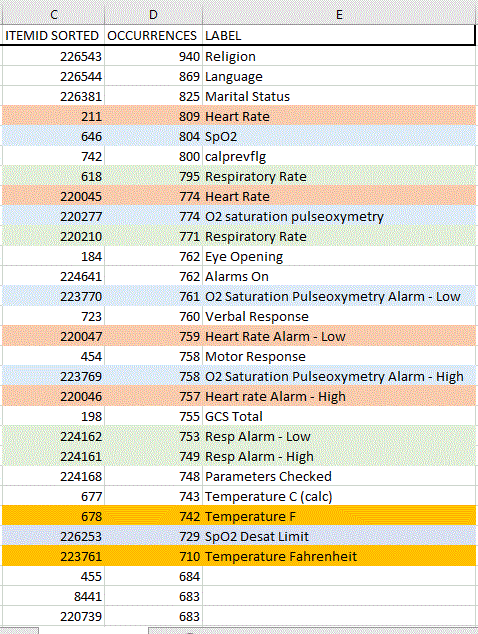

 Some of the recorded observations have different codes, but refer to the same metric. This is because the events are recorded in different databases which have different identification systems. For example, we can see the heart rate where in the carevue database it is 211 and in metavision it is 220045.

In [ ]:
#@title SQL Query for patients with hepatitis diagnose and related data
# Collect all patient data, and create an extra column "hasPreviousStay" 
# which indicates whether the petient has previous hospital stays.
# Cost: 16 mb

SELECT DISTINCT 
    newIcustay.subject_id, newIcustay.HADM_ID, newIcustay.ICUSTAY_ID, hasPreviousStay, 
    newIcustay.intime, patients.gender, patients.DOB, 
    DATE_DIFF(DATE(intime), DATE(patients.dob), YEAR) AS age,
    newDiagnoses.ICD9_CODE, admissions.ADMISSION_TYPE,
    admissions.insurance, newIcustay.los
FROM
    (WITH icustaySeq AS (
        SELECT subject_id, HADM_ID, ICUSTAY_ID, intime, los,
        ROW_NUMBER() OVER (PARTITION BY subject_id ORDER BY ICUSTAY_ID ASC) AS rownrASC,
        ROW_NUMBER() OVER (PARTITION BY subject_id ORDER BY ICUSTAY_ID DESC) AS rownrDESC
        FROM physionet-data.mimiciii_clinical.icustays) 
    SELECT subject_id, HADM_ID, ICUSTAY_ID, intime, CASE WHEN rownrASC > rownrDESC THEN 1 ELSE 0 END AS hasPreviousStay, los
    FROM icustaySeq WHERE rownrDESC = 1 ORDER BY subject_ID ASC) newIcustay
LEFT JOIN 
    (SELECT subject_id, HADM_ID, icd9_code FROM physionet-data.mimiciii_clinical.diagnoses_icd) newDiagnoses
    ON (newIcustay.subject_ID = newDiagnoses.subject_ID AND newIcustay.HADM_ID = newDiagnoses.HADM_ID)
LEFT JOIN 
    physionet-data.mimiciii_clinical.patients patients
    ON (newIcustay.subject_ID = patients.subject_ID)
LEFT JOIN 
    physionet-data.mimiciii_clinical.admissions admissions
    ON (admissions.subject_ID = newIcustay.subject_ID AND admissions.HADM_ID = newIcustay.HADM_ID)
WHERE
    newDiagnoses.ICD9_CODE in ("5733", "0700",  "0701", "07020",    "07022",    "07030",    "07032",
    "07041",    "07044",    "07051",    "07054",    "07070",    "07071",    "07021",
    "07023",    "07031",    "07033",    "07042",    "07052",    "07043",    "07053",
    "07049",    "07059",    "V0260",    "V0269")
ORDER BY newIcustay.subject_id, patients.gender ASC 

In [ ]:
#@title SQL Query selection of all chart events filtered by patients diagnosed with hepatitis.
# The medical measurements are retrieved from the chartevents table with a limit of 
# 3 hours after the patient arrival 
# Cost: 13 Gb

SELECT 
    ids.subject_id, ids.HADM_ID, ids.ICUSTAY_ID, 
    events.itemid, events.median, 
    events.average, events.minValue,
    events.maxValue, events.totalSum, 
    events.standarddev, events.var
FROM 
      (SELECT DISTINCT 
        newIcustay.subject_id, newIcustay.HADM_ID, newIcustay.ICUSTAY_ID
      FROM
        (WITH icustaySeq AS (
            SELECT subject_id, HADM_ID, ICUSTAY_ID, intime, los,
            ROW_NUMBER() OVER (PARTITION BY subject_id ORDER BY ICUSTAY_ID ASC) AS rownrASC,
            ROW_NUMBER() OVER (PARTITION BY subject_id ORDER BY ICUSTAY_ID DESC) AS rownrDESC
            FROM physionet-data.mimiciii_clinical.icustays) 
        SELECT subject_id, HADM_ID, ICUSTAY_ID, intime, CASE WHEN rownrASC > rownrDESC THEN 1 ELSE 0 END AS hasPreviousStay, los
        FROM icustaySeq WHERE rownrDESC = 1 ORDER BY subject_ID ASC) newIcustay
      LEFT JOIN 
        (SELECT subject_id, HADM_ID, icd9_code FROM physionet-data.mimiciii_clinical.diagnoses_icd) newDiagnoses
        ON (newIcustay.subject_ID = newDiagnoses.subject_ID AND newIcustay.HADM_ID = newDiagnoses.HADM_ID)
      LEFT JOIN 
        physionet-data.mimiciii_clinical.patients patients
        ON (newIcustay.subject_ID = patients.subject_ID)
      LEFT JOIN 
        physionet-data.mimiciii_clinical.admissions admissions
        ON (admissions.subject_ID = newIcustay.subject_ID AND admissions.HADM_ID = newIcustay.HADM_ID)
      WHERE
        newDiagnoses.ICD9_CODE in ("5733", "0700", "0701", "07020", "07022", "07030", "07032", "07041", "07044", "07051", "07054", "07070", "07071", "07021", "07023", "07031", "07033", "07042", "07052", "07043", "07053", "07049", "07059", "V0260", "V0269") 
    ) ids,
    (SELECT  
        chartevents.subject_id, chartevents.HADM_ID, chartevents.ICUSTAY_ID, chartevents.itemid, 
        APPROX_QUANTILES(chartevents.VALUENUM, 100)[OFFSET(50)] AS median,
        AVG(chartevents.VALUENUM) as average,
        MIN(chartevents.VALUENUM) as minValue,
        MAX(chartevents.VALUENUM) as maxValue,     
        SUM(chartevents.VALUENUM) as totalSum, 
        STDDEV(chartevents.VALUENUM) as standarddev, 
        VARIANCE(chartevents.VALUENUM) as var
    FROM
      physionet-data.mimiciii_clinical.chartevents chartevents,
      physionet-data.mimiciii_clinical.icustays icustays
    WHERE
      chartevents.subject_id = icustays.subject_id 		
      AND chartevents.HADM_ID = icustays.HADM_ID 
      AND chartevents.ICUSTAY_ID = icustays.ICUSTAY_ID
      AND chartevents.valuenum is not null
      AND ABS(DATETIME_DIFF(icustays.intime, chartevents.storetime, hour))  <= 3
      group by subject_id, hadm_id, icustay_id, chartevents.itemid
    ) events
WHERE
  ids.subject_id = events.subject_id
  AND ids.HADM_ID = events.HADM_ID
  AND ids.ICUSTAY_ID = events.ICUSTAY_ID
  order by subject_id, hadm_id, icustay_id, itemid


## Data set preprocessing:


 


The results of both SQL queries, were stored as CSV files to facilitate handling and processing. 
After analyzing the data, we decided to keep those procedures that are shared by the most patients during the initial 3-hour period.

These are:
*   Hear Rate (item ID = 211, 220045, 220047, 220046)
*   Respiratory rate (item ID = 618, 220210, 224161, 224162)
*   O2 saturation pulseoxymetry (item ID = 646, 220277, 223769, 223770)
*   Temperature (item ID = 678, 223761)

(*Item ids are different depending on the database source but they refer to the same measurement)

In [ ]:
#@title Data preprocessing procedure
# No need to RUN
# Data preprocessing (build dataset)

# Read files
eventsData = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DataAnalytics/Project/hepatitis_chartevents.csv')
hepatitisPatiensData = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DataAnalytics/Project/hepatitis_patientsData.csv')

# Drop 'var' column, we have std-dev
eventsData.drop(columns=['var'], inplace=True)
# Remove wrong age
hepatitisPatiensData.drop(hepatitisPatiensData.loc[hepatitisPatiensData['age'] > 100].index, inplace=True)

# Items for selection
hearRateItems = [211, 220045, 220046, 220047]
respiratoryRateItems = [618, 220210, 224161, 224162]
o2SaturationItems = [646, 220277, 223769, 223770]
temperatureItems = [678, 223761]

# function to match ids
def idCheck(ids, events):
    result = (events['subject_id'] == ids['subject_id']) &\
             (events['HADM_ID'] == ids['HADM_ID']) &\
             (events['ICUSTAY_ID'] == ids['ICUSTAY_ID'])
    return result

# Create dataframes per feature (item)
hearRateData = pd.DataFrame()
respiratoryRateData = pd.DataFrame()
o2SaturationData = pd.DataFrame()
temperatureData = pd.DataFrame()

# loop over hepatitis patients, and populate each dataframe
for row in range(len(hepatitisPatiensData)):
    hepRowSelection = hepatitisPatiensData.iloc[row, :]
    idIndexes = idCheck(hepRowSelection, eventsData)
    print("Patient nr: ", row)
    # Create heartRate dataframe
    for itemID in hearRateItems:     # we will check in order
        selectedEvents = eventsData.loc[idIndexes & (eventsData['itemid'] == itemID)]
        if not selectedEvents.empty:
            hearRateData = hearRateData.append(selectedEvents, ignore_index = True)
            break  # if found stop searching

    # Create Respiratory Rate dataframe
    for itemID in respiratoryRateItems:     # we will check in order
        selectedEvents = eventsData.loc[idIndexes & (eventsData['itemid'] == itemID)]
        if not selectedEvents.empty:
            respiratoryRateData = respiratoryRateData.append(selectedEvents, ignore_index = True)
            break  # if found stop searching

    # Create o2Saturation dataframe
    for itemID in o2SaturationItems:     # we will check in order
        selectedEvents = eventsData.loc[idIndexes & (eventsData['itemid'] == itemID)]
        if not selectedEvents.empty:
            o2SaturationData = o2SaturationData.append(selectedEvents, ignore_index = True)
            break  # if found stop searching

    # Create temperature dataframe
    for itemID in temperatureItems:     # we will check in order
        selectedEvents = eventsData.loc[idIndexes & (eventsData['itemid'] == itemID)]
        if not selectedEvents.empty:
            temperatureData = temperatureData.append(selectedEvents, ignore_index = True)
            break  # if found stop searching

# Drom ItemId column
hearRateData.drop(columns=['itemid'], inplace=True)
respiratoryRateData.drop(columns=['itemid'], inplace=True)
o2SaturationData.drop(columns=['itemid'], inplace=True)
temperatureData.drop(columns=['itemid'], inplace=True)

# Dropping columns from hepatitisPatiensData
hepatitisPatiensData.drop(columns=['intime', 'DOB', 'ICD9_CODE'], inplace=True)

# Rename columns
hearRateData.rename(columns={'median':'hrMedian', 'average': 'hrAverage','minValue':'hrMinValue', 'maxValue':'hrMaxValue', 'totalSum':'hrTotalSum', 'standarddev':'hrStandarddev'}, inplace=True)
respiratoryRateData.rename(columns={'median':'respMedian', 'average': 'respAverage','minValue':'respMinValue', 'maxValue':'respMaxValue', 'totalSum':'respTotalSum', 'standarddev':'respStandarddev'}, inplace=True)
o2SaturationData.rename(columns={'median':'o2SatMedian', 'average': 'o2SatAverage','minValue':'o2SatMinValue', 'maxValue':'o2SatMaxValue', 'totalSum':'o2SatTotalSum', 'standarddev':'o2SatStandarddev'}, inplace=True)
temperatureData.rename(columns={'median':'tempMedian', 'average': 'tempAverage','minValue':'tempMinValue', 'maxValue':'tempMaxValue', 'totalSum':'tempTotalSum', 'standarddev':'tempStandarddev'}, inplace=True)

# Merge dataframes
merged_data = hearRateData.merge(respiratoryRateData, on=['subject_id', 'HADM_ID', 'ICUSTAY_ID'])
merged_data = merged_data.merge(o2SaturationData, on=['subject_id', 'HADM_ID', 'ICUSTAY_ID'])
merged_data = merged_data.merge(temperatureData, on=['subject_id', 'HADM_ID', 'ICUSTAY_ID'])

# Hepatitis dataset preprocessing (change categorical for numeric)
# replacing values for gender
hepatitisPatiensData['gender'].replace(['M', 'F'], [0, 1], inplace=True)
# replace admission type (lets assign increasing values depending on the criticality of the classification)
hepatitisPatiensData['ADMISSION_TYPE'].replace(['ELECTIVE', 'EMERGENCY', 'URGENT'], [0, 1, 2], inplace=True)
# replace insurance types (lets divide between private (1) or public (0) systems)
hepatitisPatiensData['insurance'].replace(['Private', 'Medicare', 'Medicaid', 'Government', 'Self Pay'], [1, 0, 0, 0, 1], inplace=True)

#### Merge with final dataset
hepatitisData = hepatitisPatiensData.merge(merged_data, on=['subject_id', 'HADM_ID', 'ICUSTAY_ID'])
# Drop and Rearrange columns (move 'los' to the last column)
hepatitisData.drop(columns=['subject_id', 'HADM_ID', 'ICUSTAY_ID'], inplace=True)
loscolumn = hepatitisData.pop('los')
hepatitisData.insert(hepatitisData.shape[1], 'los', loscolumn)

# Check NAN values per column
# nanValues = []
# for c in hepatitisData.columns:
#     nanValues.append({c: hepatitisData[c].isna().sum()})
# hepatitisData.drop(columns=['tempStandarddev'], inplace=True)  # too many NAN values

# Drop columns with more than 25% Nan values
for c in hepatitisData.columns:
    if (hepatitisData[c].isnull().sum() > (len(hepatitisData)/4)):
        hepatitisData.drop(columns=[c], inplace=True)

# Replace Nan values with Average
for c in hepatitisData.columns:
    if hepatitisData[c].isnull().values.any():
        meanValue = hepatitisData[c].mean()
        hepatitisData[c].fillna(meanValue, inplace=True)

# hepatitisData.shape
#hepatitisData.to_csv(r'hepatitisData.csv', index=False)
hepatitisData.isnull().any()

In [ ]:
#Reading data file
import pandas as pd

#hepatitisData_regression = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_Analytics/hepatitisData.csv')
hepatitisData_regression = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DataAnalytics/Project/hepatitisData.csv')

## Data analysis and visualisations:

In [ ]:
#@title Dataset description
hepatitisData_regression.describe()

,hasPreviousStay,gender,age,ADMISSION_TYPE,insurance,hrMedian,hrAverage,hrMinValue,hrMaxValue,hrTotalSum,...,o2SatMinValue,o2SatMaxValue,o2SatTotalSum,o2SatStandarddev,tempMedian,tempAverage,tempMinValue,tempMaxValue,tempTotalSum,los
count,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,...,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000
mean,0.319328,0.321429,52.798319,0.966387,0.306723,89.435574,90.553023,85.028011,96.701681,454.967087,...,95.448880,98.610644,466.449580,1.497034,97.624790,97.793824,97.496779,98.054972,142.501681,4.186987
std,0.466380,0.467188,12.367983,0.273043,0.461295,19.358946,19.041144,18.848507,20.901258,337.984995,...,6.228271,2.123305,297.918268,2.350304,5.798102,4.748417,6.360860,4.211729,93.369699,5.550253
min,0.000000,0.000000,17.000000,0.000000,0.000000,34.000000,33.666667,0.000000,37.000000,50.000000,...,0.000000,69.000000,89.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250900
25%,0.000000,0.000000,46.000000,1.000000,0.000000,76.000000,77.000000,72.000000,82.000000,252.000000,...,94.000000,98.000000,289.000000,0.517261,97.000000,97.100000,97.000000,97.200000,97.600000,1.229550
50%,0.000000,0.000000,53.000000,1.000000,0.000000,88.000000,89.250000,84.000000,95.000000,362.000000,...,97.000000,100.000000,391.000000,1.078356,98.000000,98.099998,98.000000,98.100000,98.750000,2.215050
75%,1.000000,1.000000,60.000000,1.000000,1.000000,102.000000,103.566667,97.000000,110.000000,545.250000,...,99.000000,100.000000,579.000000,1.732051,98.900000,98.900002,98.900000,99.100000,194.124999,4.523900
max,1.000000,1.000000,89.000000,2.000000,1.000000,161.000000,164.333333,148.000000,181.000000,3753.000000,...,100.000000,100.000000,2410.000000,42.507842,106.000000,106.049999,106.000000,107.599998,1183.899986,55.996700


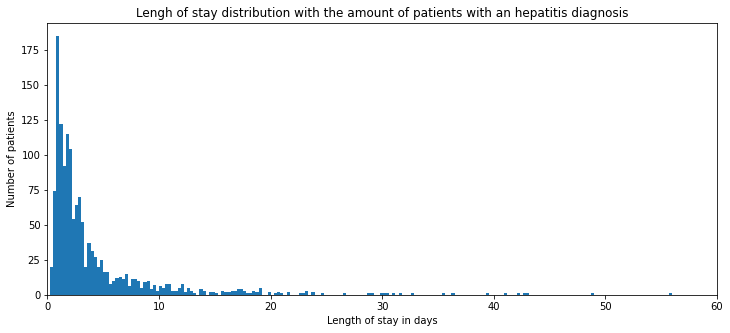

In [ ]:
#@title
# Plot LOS Distribution across the number of patients
plt.figure(figsize=(12,5))
plt.hist(hepatitisData_regression['los'], bins=200)
plt.xlim(0, 60)
plt.title('Lengh of stay distribution with the amount of patients with an hepatitis diagnosis')
plt.ylabel('Number of patients')
plt.xlabel('Length of stay in days')
plt.show();

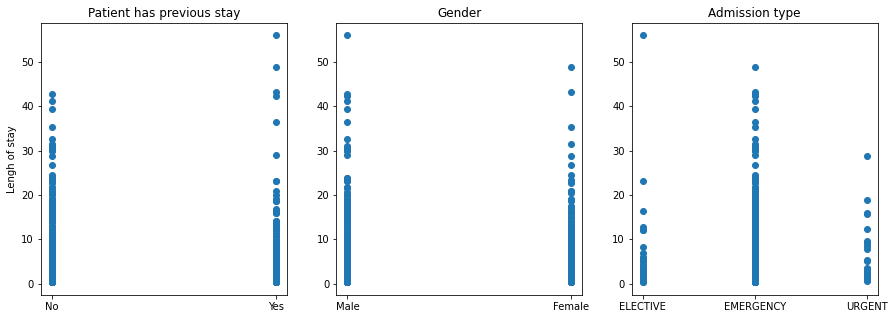

In [ ]:
#@title Previous stay, gender and admission type versus lengh of stay 
# Previous stay 
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1) # row 1, col 2 index 1
plt.scatter(hepatitisData_regression['hasPreviousStay'], hepatitisData_regression['los'])
plt.title("Patient has previous stay")
plt.xticks([0,1],['No','Yes']) 
plt.ylabel('Lengh of stay')
# Gender
plt.subplot(1, 3, 2)  
plt.scatter(hepatitisData_regression['gender'], hepatitisData_regression['los'])
plt.title('Gender')
plt.xticks([0,1],['Male', 'Female'])
# Admission type
plt.subplot(1, 3, 3)  
plt.scatter(hepatitisData_regression['ADMISSION_TYPE'], hepatitisData_regression['los'])
plt.title('Admission type')
plt.xticks([0, 1, 2], ['ELECTIVE', 'EMERGENCY', 'URGENT'])
plt.show()
print("\n")

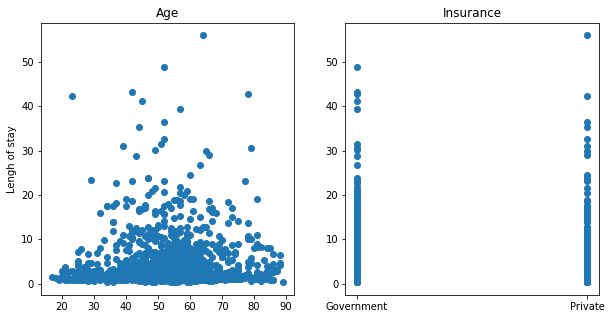

In [ ]:
#@title Age and Insurance versus lengh of stay 
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)  
plt.scatter(hepatitisData_regression['age'], hepatitisData_regression['los'])
plt.title('Age')
plt.ylabel('Lengh of stay')
#plt.xticks(tickLabels[idx][0], tickLabels[idx][1])
#'age', 'insurance'
plt.subplot(1, 2, 2)  
plt.scatter(hepatitisData_regression['insurance'], hepatitisData_regression['los'])
plt.title('Insurance')
plt.xticks([0, 1], ['Government', 'Private']) 
plt.show()


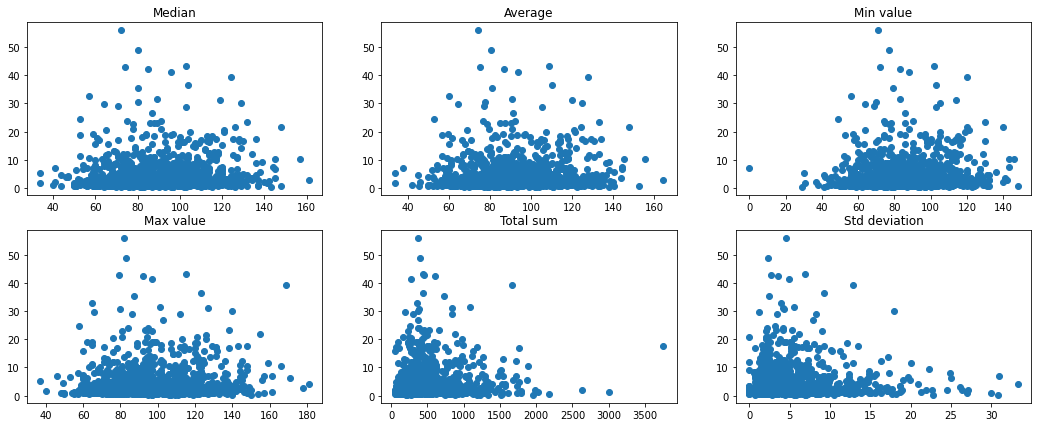

In [ ]:
#@title Heart Rate measurements versus lengh of say 

hrCols = ['hrMedian', 'hrAverage', 'hrMinValue', 'hrMaxValue', 'hrTotalSum', 'hrStandarddev']
hrTitles = ['Median', 'Average', 'Min value', 'Max value', 'Total sum', 'Std deviation']

plt.figure(figsize=(18,7))
for i in range(len(hrCols)):
  plt.subplot(2, 3, i+1)  
  plt.scatter(hepatitisData_regression[hrCols[i]], hepatitisData_regression['los'])
  plt.title(hrTitles[i])

plt.show()

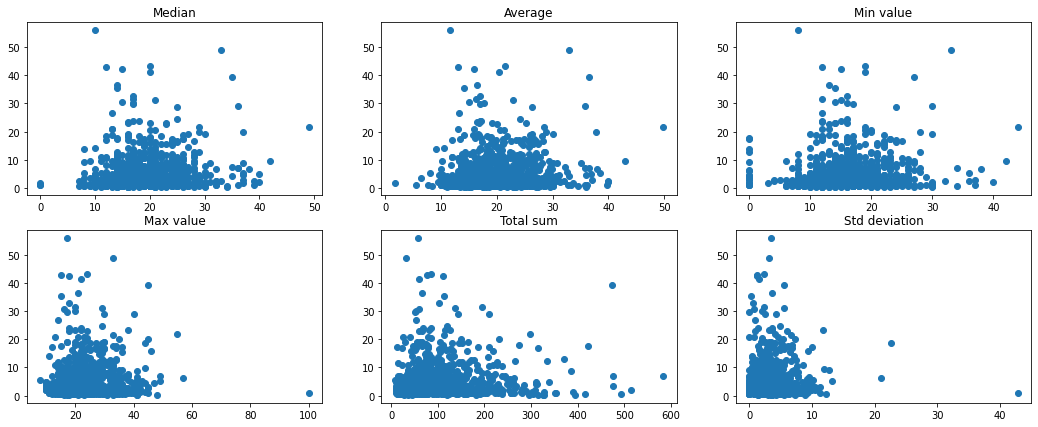

In [ ]:
#@title Respiratory Rate measurements versus lengh of say 
respCols = ['respMedian', 'respAverage', 'respMinValue', 'respMaxValue', 'respTotalSum', 'respStandarddev']
respTitles = ['Median', 'Average', 'Min value', 'Max value', 'Total sum', 'Std deviation']

plt.figure(figsize=(18,7))
for i in range(len(respCols)):
  plt.subplot(2, 3, i+1)  
  plt.scatter(hepatitisData_regression[respCols[i]], hepatitisData_regression['los'])
  plt.title(respTitles[i])

plt.show()

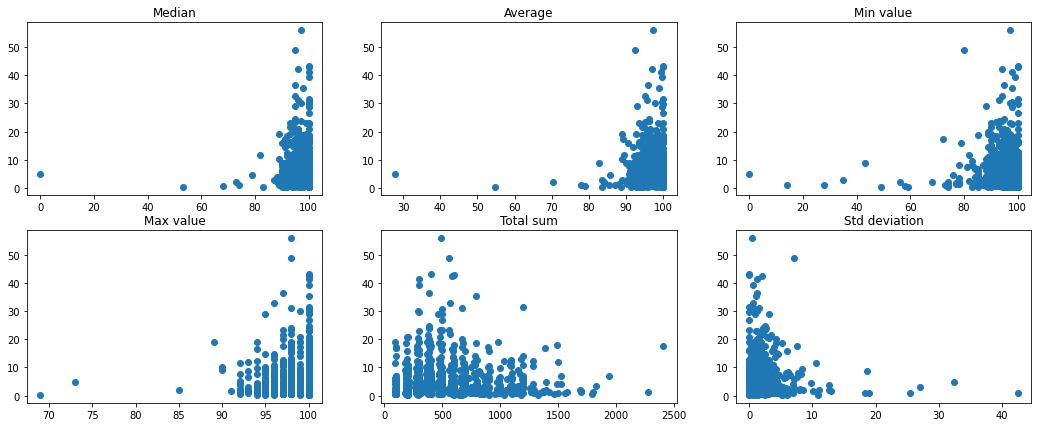

In [ ]:
#@title O2 Saturation measurements versus lengh of say

o2Cols = ['o2SatMedian', 'o2SatAverage', 'o2SatMinValue', 'o2SatMaxValue', 'o2SatTotalSum', 'o2SatStandarddev']
o2Titles = ['Median', 'Average', 'Min value', 'Max value', 'Total sum', 'Std deviation']

plt.figure(figsize=(18,7))
for i in range(len(o2Cols)):
  plt.subplot(2, 3, i+1)  
  plt.scatter(hepatitisData_regression[o2Cols[i]], hepatitisData_regression['los'])
  plt.title(o2Titles[i])

plt.show()

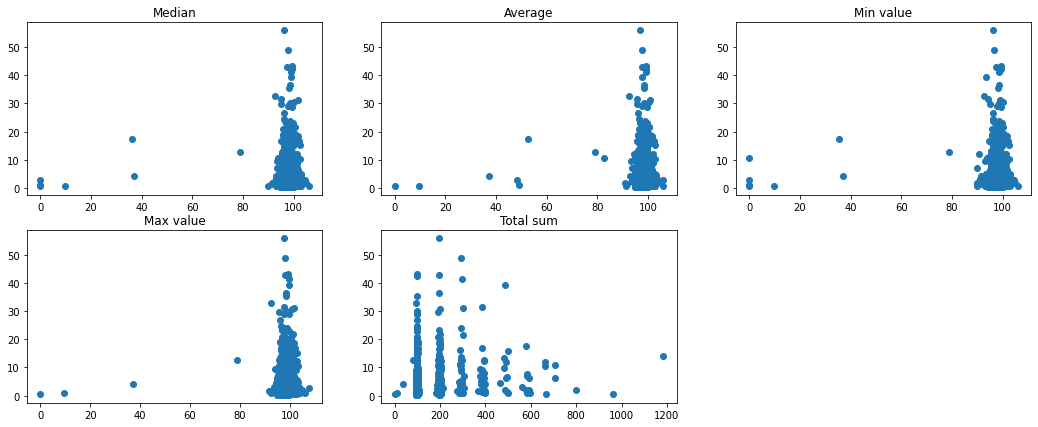

In [ ]:
#@title Temperature measurements versus lengh of say

tempCols = ['tempMedian', 'tempAverage', 'tempMinValue','tempMaxValue', 'tempTotalSum']
tempTitles = ['Median', 'Average', 'Min value', 'Max value', 'Total sum']

plt.figure(figsize=(18,7))
for i in range(len(tempCols)):
  plt.subplot(2, 3, i+1)  
  plt.scatter(hepatitisData_regression[tempCols[i]], hepatitisData_regression['los'])
  plt.title(tempTitles[i])

plt.show()

## Supervised Machine Learning - Regression with PCA

To find the best model for our research, we will first apply PC Analysis on a normalized dataset to reduce the number of features and improve the model efficiency.

### Splitting Data into training/test sets and applying PCA

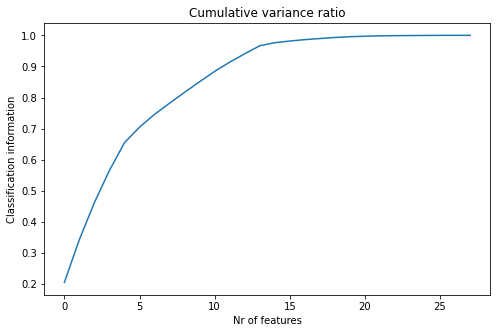

15 Features cumulative sum:  97.64 %


In [ ]:
#@title Normalization and PCAnalysis

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# dataset and targets
X = hepatitisData_regression.loc[:, hepatitisData_regression.columns != 'los']
y = hepatitisData_regression[['los']].values

# split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

#Normalize data
scaler = StandardScaler()
X_train_normal = scaler.fit_transform(X_train)
X_test_normal = scaler.transform(X_test)

# Calculate variance ratios with PCA 
pca = PCA()
X_train_pca = pca.fit_transform(X_train_normal)
X_test_pca = pca.transform(X_test_normal)

# Plot features pca var ratios
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative variance ratio')
plt.xlabel('Nr of features')
plt.ylabel('Classification information')
plt.show()

print('15 Features cumulative sum: ', round(sum(pca.explained_variance_ratio_[0:15])*100,2), '%')

# Select features using PCA (components = 15)
pca = PCA(n_components=15)
X_train = pca.fit_transform(X_train_normal)
X_test = pca.transform(X_test)

In the figure "Cumulative variance ratio" we observe that 97.64%% percent of the classification information contained in the feature set is captured by the first 15 principal components. We will select these 15 components to train our model.

### Regression using Support Vector Machines

In [ ]:
#@title Grid search (Support vector machines)
# Use cross validation to find the most performant model with the best configuration of hiper parameters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn import tree, svm

# parameters set
parameters = {'C': [0.1, 1, 10, 100], 'gamma':['scale', 'auto'], 'kernel': ['linear', 'poly', 'rbf',]}  

# SVM regression model
svm_clf = svm.SVR()

# Fit 5 fold cross validation
svm_cv = GridSearchCV(svm_clf, param_grid = parameters, cv= 5, verbose=3)
svm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.095 total time=   0.0s
[CV 2/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.096 total time=   0.0s
[CV 3/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.056 total time=   0.0s
[CV 4/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.105 total time=   0.0s
[CV 5/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.028 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.124 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.117 total time=   0.0s
[CV 3/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-1.014 total time=   0.0s
[CV 4/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.147 total time=   0.0s
[CV 5/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.019 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=rbf;, score=-0.105 total time=   0.1s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=rbf;

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             verbose=3)

In [ ]:
#@title Support vector machine best parameters 
print(svm_cv.best_params_)

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
#@title SVM Regression
# Applying best parameters to SVM
from sklearn.svm import SVR
import numpy as np
from sklearn.metrics import accuracy_score

# Using best parameters found above to train SVM classifier
svm_regr = SVR(kernel = 'rbf',C=10, gamma = 'auto')
# Fitting model to training data
svm_regr.fit(X_train, y_train)
predictions = svm_regr.predict(X_test)
# Accuracy score for the model
svr_score = svm_regr.score(X_test,y_test, sample_weight=None)
print(svr_score)


-0.0024710057736905267


In [ ]:
print('Regression Evaluation Matrices for SVM Regression')
print('\n')
# To print the Mean Absolute Error Method 
print("Mean Absolute Error of our dataset is:",(metrics.mean_absolute_error(y_test,predictions)))

print('\n')

# To print the Mean Square Error Method 
print("Mean Square Error of our dataset is:",(metrics.mean_squared_error(y_test,predictions)))

print('\n')

# To print the Root Mean Square Error Method
print('Root Mean Square Error of our dataset is:',(np.sqrt(metrics.mean_squared_error(y_test,predictions))))

Regression Evaluation Matrices for SVM Regression


Mean Absolute Error of our dataset is: 3.7102159395233687


Mean Square Error of our dataset is: 33.04044020151285


Root Mean Square Error of our dataset is: 5.748081436576282


### Regression using Random Forest

In [ ]:
#@title Grid search (Random forest)

# Random forest regression parameters test
from sklearn.ensemble import RandomForestRegressor

# parameters set
parameters = {'n_estimators':[50, 100, 150, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8]}

# Random Fores model
rf_clf = RandomForestRegressor(random_state=42) 

# Fit 5 fold cross validation
rf_cv = GridSearchCV(rf_clf, param_grid = parameters, cv= 5, verbose=3)
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END max_depth=4, max_features=auto, n_estimators=50;, score=-0.023 total time=   0.4s
[CV 2/5] END max_depth=4, max_features=auto, n_estimators=50;, score=-0.094 total time=   0.4s
[CV 3/5] END max_depth=4, max_features=auto, n_estimators=50;, score=-0.010 total time=   0.3s
[CV 4/5] END max_depth=4, max_features=auto, n_estimators=50;, score=-0.040 total time=   0.5s
[CV 5/5] END max_depth=4, max_features=auto, n_estimators=50;, score=-0.026 total time=   0.4s
[CV 1/5] END max_depth=4, max_features=auto, n_estimators=100;, score=-0.055 total time=   0.8s
[CV 2/5] END max_depth=4, max_features=auto, n_estimators=100;, score=-0.079 total time=   0.7s
[CV 3/5] END max_depth=4, max_features=auto, n_estimators=100;, score=0.002 total time=   0.7s
[CV 4/5] END max_depth=4, max_features=auto, n_estimators=100;, score=-0.046 total time=   0.7s
[CV 5/5] END max_depth=4, max_features=auto, n_estimators=100;, score=-0.027 tot

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=3)

In [ ]:
#@title Random forest best parameters:
print(rf_cv.best_params_)

{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}


In [ ]:
#@title Random Forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

rf_regr = RandomForestRegressor(max_depth=5, max_features='sqrt',n_estimators=50)
rf_regr.fit(X_train, y_train)
regr_prediction = rf_regr.predict(X_test)
regr_score = rf_regr.score(X_test,y_test)

print(regr_score)

-6.061567048087583


In [ ]:
print('Regression Evaluation Matrices for Random Forest Regressor')
print('\n')
# To print the Mean Absolute Error Method 
print("Mean Absolute Error of our dataset is:",(metrics.mean_absolute_error(y_test,regr_prediction)))

print('\n')

# To print the Mean Square Error Method 
print("Mean Square Error of our dataset is:",(metrics.mean_squared_error(y_test,regr_prediction)))

print('\n')

# To print the Root Mean Square Error Method
print('Root Mean Square Error of our dataset is:',(np.sqrt(metrics.mean_squared_error(y_test,regr_prediction))))

Regression Evaluation Matrices for Random Forest Regressor


Mean Absolute Error of our dataset is: 14.642165862123282


Mean Square Error of our dataset is: 232.74217651935078


Root Mean Square Error of our dataset is: 15.255889896015598


### Regression using Multi Perceptron (NN)

In [ ]:
#@title Grid search (neural networks)
# Neural networks 
from sklearn.neural_network import MLPRegressor

# parameters set
parameters = {'learning_rate': ["constant", "invscaling", "adaptive"], 'hidden_layer_sizes': [(10,1), (15,1), (10,2), (15,2)], 'activation': ["logistic", "relu", "Tanh"]}

# Multi perceptron regression model
nn_clf = MLPRegressor(max_iter=200) 

# Fit 5 fold cross validation
nn_cv = GridSearchCV(nn_clf, param_grid = parameters, cv= 5, verbose=3)
nn_cv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=-0.070 total time=   0.4s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=-0.051 total time=   0.4s
[CV 3/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=-0.389 total time=   0.4s
[CV 4/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=-0.292 total time=   0.4s
[CV 5/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=-0.664 total time=   0.4s
[CV 1/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=invscaling;, score=-0.309 total time=   0.4s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=invscaling;, score=-0.245 total time=   0.4s
[CV 3/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=invscaling;, score=-0.079

GridSearchCV(cv=5, estimator=MLPRegressor(),
             param_grid={'activation': ['logistic', 'relu', 'Tanh'],
                         'hidden_layer_sizes': [(10, 1), (15, 1), (10, 2),
                                                (15, 2)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             verbose=3)

In [ ]:
#@title Multi perceptron best parameters
print(nn_cv.best_params_)

{'activation': 'relu', 'hidden_layer_sizes': (10, 2), 'learning_rate': 'adaptive'}


In [ ]:
#@title Multi Perceptron regression
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
# Applying best parameters found above to Multi perceptron classifier
mlp_regr = MLPRegressor(activation='relu',hidden_layer_sizes=(10,2),learning_rate='adaptive')
# Fitting model to training data
mlp_regr.fit(X_train, y_train)
reml_prediction = mlp_regr.predict(X_test)
# Multi Perceptron Score
sreml_score = mlp_regr.score(X_test,y_test)
print(sreml_score)


-1115.6697558526796


In [ ]:
print('Regression Evaluation Matrices for Multi Perceptron regression')
print('\n')
# To print the Mean Absolute Error Method 
print("Mean Absolute Error of our dataset is:",(metrics.mean_absolute_error(y_test,reml_prediction)))

print('\n')

# To print the Mean Square Error Method 
print("Mean Square Error of our dataset is:",(metrics.mean_squared_error(y_test,reml_prediction)))

print('\n')

# To print the Root Mean Square Error Method
print('Root Mean Square Error of our dataset is:',(np.sqrt(metrics.mean_squared_error(y_test,reml_prediction))))

Regression Evaluation Matrices for Multi Perceptron regression


Mean Absolute Error of our dataset is: 157.3396627762381


Mean Square Error of our dataset is: 36804.3166142379


Root Mean Square Error of our dataset is: 191.84451155620246


# Classification Methods

## Data analysis and visualisations:

In [ ]:
hepatitisData = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DataAnalytics/Project/hepatitisData.csv')

In [ ]:
#@title Dataset description
hepatitisData.describe()

,hasPreviousStay,gender,age,ADMISSION_TYPE,insurance,hrMedian,hrAverage,hrMinValue,hrMaxValue,hrTotalSum,...,o2SatMinValue,o2SatMaxValue,o2SatTotalSum,o2SatStandarddev,tempMedian,tempAverage,tempMinValue,tempMaxValue,tempTotalSum,los
count,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,...,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000
mean,0.319328,0.321429,52.798319,0.966387,0.306723,89.435574,90.553023,85.028011,96.701681,454.967087,...,95.448880,98.610644,466.449580,1.497034,97.624790,97.793824,97.496779,98.054972,142.501681,4.186987
std,0.466380,0.467188,12.367983,0.273043,0.461295,19.358946,19.041144,18.848507,20.901258,337.984995,...,6.228271,2.123305,297.918268,2.350304,5.798102,4.748417,6.360860,4.211729,93.369699,5.550253
min,0.000000,0.000000,17.000000,0.000000,0.000000,34.000000,33.666667,0.000000,37.000000,50.000000,...,0.000000,69.000000,89.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250900
25%,0.000000,0.000000,46.000000,1.000000,0.000000,76.000000,77.000000,72.000000,82.000000,252.000000,...,94.000000,98.000000,289.000000,0.517261,97.000000,97.100000,97.000000,97.200000,97.600000,1.229550
50%,0.000000,0.000000,53.000000,1.000000,0.000000,88.000000,89.250000,84.000000,95.000000,362.000000,...,97.000000,100.000000,391.000000,1.078356,98.000000,98.099998,98.000000,98.100000,98.750000,2.215050
75%,1.000000,1.000000,60.000000,1.000000,1.000000,102.000000,103.566667,97.000000,110.000000,545.250000,...,99.000000,100.000000,579.000000,1.732051,98.900000,98.900002,98.900000,99.100000,194.124999,4.523900
max,1.000000,1.000000,89.000000,2.000000,1.000000,161.000000,164.333333,148.000000,181.000000,3753.000000,...,100.000000,100.000000,2410.000000,42.507842,106.000000,106.049999,106.000000,107.599998,1183.899986,55.996700


In [ ]:
#@title Dataframe Columns
# Checking dataframe columns
hepatitisData.columns

Index(['hasPreviousStay', 'gender', 'age', 'ADMISSION_TYPE', 'insurance',
       'hrMedian', 'hrAverage', 'hrMinValue', 'hrMaxValue', 'hrTotalSum',
       'hrStandarddev', 'respMedian', 'respAverage', 'respMinValue',
       'respMaxValue', 'respTotalSum', 'respStandarddev', 'o2SatMedian',
       'o2SatAverage', 'o2SatMinValue', 'o2SatMaxValue', 'o2SatTotalSum',
       'o2SatStandarddev', 'tempMedian', 'tempAverage', 'tempMinValue',
       'tempMaxValue', 'tempTotalSum', 'los'],
      dtype='object')

In [ ]:
#@title Categorizing LOS into ranges for classification task
# Categorizing target variable (LOS) into ranges of days

bins = [0,1,2,3,4,5,60]
labels = ['0-1','1-2','2-3','3-4','4-5','5+']
hepatitisData['los'] = pd.cut(hepatitisData['los'], bins=bins, labels=labels)

In [ ]:
hepatitisData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   hasPreviousStay   1428 non-null   int64   
 1   gender            1428 non-null   int64   
 2   age               1428 non-null   int64   
 3   ADMISSION_TYPE    1428 non-null   int64   
 4   insurance         1428 non-null   int64   
 5   hrMedian          1428 non-null   float64 
 6   hrAverage         1428 non-null   float64 
 7   hrMinValue        1428 non-null   float64 
 8   hrMaxValue        1428 non-null   float64 
 9   hrTotalSum        1428 non-null   float64 
 10  hrStandarddev     1428 non-null   float64 
 11  respMedian        1428 non-null   float64 
 12  respAverage       1428 non-null   float64 
 13  respMinValue      1428 non-null   float64 
 14  respMaxValue      1428 non-null   float64 
 15  respTotalSum      1428 non-null   float64 
 16  respStandarddev   1428 n

In [ ]:
#@title Scaling non-binary features, splitting data into features and label & splitting data into training/test datasets
# Applying standardScaler normalization to all non-binary variables.
t= ColumnTransformer(transformers =[
    ('scale',StandardScaler(), ['age','hrMedian','hrAverage', 'hrMinValue', 'hrMaxValue', 'hrTotalSum',
       'hrStandarddev', 'respMedian', 'respAverage', 'respMinValue',
       'respMaxValue', 'respTotalSum', 'respStandarddev', 'o2SatMedian',
       'o2SatAverage', 'o2SatMinValue', 'o2SatMaxValue', 'o2SatTotalSum',
       'o2SatStandarddev', 'tempMedian', 'tempAverage', 'tempMinValue',
       'tempMaxValue', 'tempTotalSum'])], remainder='passthrough')

# Splitting data into features and label/result 
features = t.fit_transform(hepatitisData.iloc[:,:-1])
result = hepatitisData.iloc[:,-1]



# split in train and test sets
X_tr, X_te, y_tr, y_te = train_test_split(features, result, test_size=0.33, shuffle=True, random_state=42)




In [ ]:
# Checking if there are any Nan target variable values after binning
resultod = pd.DataFrame(result)
resultod.isna().sum().sum()

0

## Supervised Machine Learning (Classification) without PCA

### Classification using Support Vector Machine Classifier

In [ ]:
#@title Grid search (Support vector machines)
# Use cross validation to find the most performant model with the best configuration of hiper parameters


# parameters set
parametersSVM = {'C': [0.1, 1, 10, 100], 'gamma':['scale', 'auto'], 'kernel': ['linear', 'rbf']}  

# SVM Classification model
svm_clf = SVC(class_weight='balanced')

# Fit 5 fold cross validation
svm_cv = GridSearchCV(svm_clf, param_grid = parametersSVM, cv= 5, verbose=3)
svm_cv.fit(X_tr, y_tr)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.182 total time=   0.1s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.215 total time=   0.1s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.162 total time=   0.1s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.236 total time=   0.1s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.183 total time=   0.1s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.177 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.262 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.257 total time=   0.1s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.314 total time=   0.1s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.257 total time=   0.1s
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.182 total time=   0.1s
[CV 2/5] END ..C=0.1, gamma=auto, kernel=linear;

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

In [ ]:
#@title Support vector machine best parameters 
print(svm_cv.best_params_)

{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
#@title Using best hyper parameters for training the classifier
# Using best found parameters to train SVM classifier
svm = SVC(kernel = 'rbf',C=0.1, gamma = 'auto',class_weight='balanced')
# Fitting model to training data
svm.fit(X_tr, y_tr)
predictionss = svm.predict(X_te)


print("accuracy score for SVM classifier is: ",accuracy_score(y_te,predictionss))



accuracy score for SVM classifier is:  0.3114406779661017


In [ ]:
#@title Classification report for SVM
# Printing classification report for SVM
print(classification_report(y_te, predictionss))

              precision    recall  f1-score   support

         0-1       0.29      0.06      0.10        79
         1-2       0.33      0.54      0.41       131
         2-3       0.25      0.26      0.26        85
         3-4       1.00      0.06      0.11        35
         4-5       0.06      0.06      0.06        34
          5+       0.38      0.42      0.40       108

    accuracy                           0.31       472
   macro avg       0.39      0.23      0.22       472
weighted avg       0.35      0.31      0.28       472



### Classification using Random Forest Classifier



In [ ]:
#@title Grid search (Random forest)

# Random forest regression parameters test

# parameters set
parametersrf = {'n_estimators':[50, 100, 150, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8]}

# Random Forest model
rf_clf = RandomForestClassifier(random_state=42,class_weight='balanced') 

# Fit 5 fold cross validation
rf_cv_clf = GridSearchCV(rf_clf, param_grid = parametersrf, cv= 5, verbose=3)
rf_cv_clf.fit(X_tr, y_tr)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END max_depth=4, max_features=auto, n_estimators=50;, score=0.229 total time=   0.1s
[CV 2/5] END max_depth=4, max_features=auto, n_estimators=50;, score=0.168 total time=   0.1s
[CV 3/5] END max_depth=4, max_features=auto, n_estimators=50;, score=0.241 total time=   0.1s
[CV 4/5] END max_depth=4, max_features=auto, n_estimators=50;, score=0.230 total time=   0.1s
[CV 5/5] END max_depth=4, max_features=auto, n_estimators=50;, score=0.199 total time=   0.1s
[CV 1/5] END max_depth=4, max_features=auto, n_estimators=100;, score=0.276 total time=   0.2s
[CV 2/5] END max_depth=4, max_features=auto, n_estimators=100;, score=0.188 total time=   0.2s
[CV 3/5] END max_depth=4, max_features=auto, n_estimators=100;, score=0.225 total time=   0.2s
[CV 4/5] END max_depth=4, max_features=auto, n_estimators=100;, score=0.241 total time=   0.2s
[CV 5/5] END max_depth=4, max_features=auto, n_estimators=100;, score=0.173 total time= 

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=3)

In [ ]:
#@title Random forest best parameters:
print(rf_cv_clf.best_params_)

{'max_depth': 8, 'max_features': 'log2', 'n_estimators': 150}


In [ ]:
#@title Using best parameters found above to train RF classifier
# Training the classifier using the best parameters found above
rf = RandomForestClassifier(max_depth=8, max_features='log2',n_estimators=150,class_weight='balanced')
# Fitting model to training data
rf.fit(X_tr, y_tr)
rf_prediction = rf.predict(X_te)
rf_score = rf.score(X_te,y_te)

print("Random Forest Classifier accuracy score is :",rf_score)



Random Forest Classifier accuracy score is : 0.2584745762711864


In [ ]:
#@title Classification report for RF classifier
# Printing classification report for Random Forest classifier
print(classification_report(y_te, rf_prediction))

              precision    recall  f1-score   support

         0-1       0.23      0.18      0.20        79
         1-2       0.28      0.37      0.32       131
         2-3       0.18      0.14      0.16        85
         3-4       0.08      0.06      0.07        35
         4-5       0.00      0.00      0.00        34
          5+       0.33      0.43      0.37       108

    accuracy                           0.26       472
   macro avg       0.18      0.19      0.19       472
weighted avg       0.23      0.26      0.24       472



### Classification using Neural Networks (Multi Perceptron)



In [ ]:
#@title Grid search (neural networks)
# Neural networks 

# parameters set
parametersNN = {'learning_rate': ["constant", "invscaling", "adaptive"], 'hidden_layer_sizes': [(10,1), (15,1), (10,2), (15,2)], 'activation': ["logistic", "relu", "Tanh"]}

# Multi perceptron classifier model
nn_clf_classifier = MLPClassifier(max_iter=200) 

# Fit 5 fold cross validation
nn_cv_clf = GridSearchCV(nn_clf_classifier, param_grid = parametersNN, cv= 5, verbose=3)
nn_cv_clf.fit(X_tr, y_tr)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=0.318 total time=   0.6s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=0.346 total time=   0.6s
[CV 3/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=0.293 total time=   0.6s
[CV 4/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=0.298 total time=   0.6s
[CV 5/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=0.298 total time=   0.6s
[CV 1/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=invscaling;, score=0.370 total time=   0.5s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=invscaling;, score=0.298 total time=   0.6s
[CV 3/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=invscaling;, score=0.298 total t

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'activation': ['logistic', 'relu', 'Tanh'],
                         'hidden_layer_sizes': [(10, 1), (15, 1), (10, 2),
                                                (15, 2)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             verbose=3)

In [ ]:
#@title Multi perceptron best parameters
print(nn_cv_clf.best_params_)

{'activation': 'logistic', 'hidden_layer_sizes': (10, 2), 'learning_rate': 'invscaling'}


In [ ]:
#@title Using best parameters found above to train Multi Perceptron classifier
# Using best parameters to train NN classifier
nn_clf_clf = MLPClassifier(max_iter=200,activation='relu',hidden_layer_sizes=(15,2),learning_rate='adaptive')
# Fitting model to training data
nn_clf_clf.fit(X_tr,y_tr)
nn_clf_clf.predict_proba(X_te[:1])
nn_clf_clf.predict(X_te[:5, :])


print("Multi Perceptron accuracy score is :",nn_clf_clf.score(X_te, y_te))


Multi Perceptron accuracy score is : 0.3008474576271186


## Supervised Machine Learning (Classification) with PCA

PCA analysis will be applied to data in order to select important features, after which the same algorithms will be used.
To find the best model for our research, we will first apply PC Analysis on a normalized dataset to reduce the number of features and improve the model efficiency.

In [ ]:
hepatitisDataPCA = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DataAnalytics/Project/hepatitisData.csv')

### Preprocessing Dataset

In [ ]:
#@title Categorizing LOS into ranges of days for classification task

# Categorizing target variable (LOS) into ranges of days

bins_PCA = [0,1,2,3,4,5,60]
labels_PCA = ['0-1','1-2','2-3','3-4','4-5','5+']
hepatitisDataPCA['los'] = pd.cut(hepatitisDataPCA['los'], bins=bins_PCA, labels=labels_PCA)



TypeError: ignored

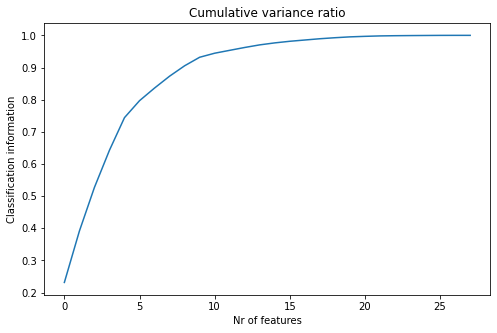

Features cumulative sum:  97.66 %


In [ ]:
#@title Normalization and PCAnalysis


# dataset and targets
tpca= ColumnTransformer(transformers =[
    ('scale',StandardScaler(), ['age','hrMedian','hrAverage', 'hrMinValue', 'hrMaxValue', 'hrTotalSum',
       'hrStandarddev', 'respMedian', 'respAverage', 'respMinValue',
       'respMaxValue', 'respTotalSum', 'respStandarddev', 'o2SatMedian',
       'o2SatAverage', 'o2SatMinValue', 'o2SatMaxValue', 'o2SatTotalSum',
       'o2SatStandarddev', 'tempMedian', 'tempAverage', 'tempMinValue',
       'tempMaxValue', 'tempTotalSum'])], remainder='passthrough')
# Creating separate dataframes for features and label
featurespca = tpca.fit_transform(hepatitisDataPCA.iloc[:,:-1])
resultpca = hepatitisDataPCA.iloc[:,-1]





# split in train and test sets
X_trainpca, X_testpca, y_trainpca, y_testpca = train_test_split(featurespca, resultpca, test_size=0.33, shuffle=True, random_state=42)


# Calculate variance ratios with PCA 
pca = PCA()
X_trainpca = pca.fit_transform(X_trainpca)
X_testpca = pca.transform(X_testpca)

# Plot features pca var ratios
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative variance ratio')
plt.xlabel('Nr of features')
plt.ylabel('Classification information')
plt.show()

print('Features cumulative sum: ', round(sum(pca.explained_variance_ratio_[0:15])*100,2), '%')

# Select features using PCA (components = 9)
pca = PCA(n_components=9)
X_trainpca = pca.fit_transform(X_trainpca)
X_testpca = pca.transform(X_testpca)

### Classification using Support Vector Machine with PCA

In [ ]:
from sklearn.svm import SVC
# SVM WITH PCA
#@title Grid search (Support vector machines) With PCA
# Use cross validation to find the most performant model with the best configuration of hiper parameters

# parameters set
parametersSVMPCA = {'C': [0.01, 0.1, 1, 10], 'gamma':['scale', 'auto'], 'kernel': ['linear', 'rbf']}  

# SVM classification model
svm_clf_PCA = SVC()

# Fit 5 fold cross validation
svm_cv_PCA = GridSearchCV(svm_clf_PCA, param_grid = parametersSVMPCA, cv= 5, verbose=3)
svm_cv_PCA.fit(X_trainpca, y_trainpca)



Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END C=0.01, gamma=scale, kernel=linear;, score=0.344 total time=   0.0s
[CV 2/5] END C=0.01, gamma=scale, kernel=linear;, score=0.330 total time=   0.0s
[CV 3/5] END C=0.01, gamma=scale, kernel=linear;, score=0.304 total time=   0.0s
[CV 4/5] END C=0.01, gamma=scale, kernel=linear;, score=0.356 total time=   0.0s
[CV 5/5] END C=0.01, gamma=scale, kernel=linear;, score=0.330 total time=   0.0s
[CV 1/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.297 total time=   0.1s
[CV 2/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.298 total time=   0.1s
[CV 3/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.298 total time=   0.1s
[CV 4/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.298 total time=   0.1s
[CV 5/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.298 total time=   0.1s
[CV 1/5] END .C=0.01, gamma=auto, kernel=linear;, score=0.344 total time=   0.0s
[CV 2/5] END .C=0.01, gamma=auto, kernel=linear;

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

In [ ]:
#@title Support vector machine best parameters 
print(svm_cv_PCA.best_params_)

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
#@title  Using best parameters found above to train SVM classifier
# Using best parameters found above to train SVM classifier
svm_PCA = SVC(kernel = 'rbf',C=1, gamma = 'scale')
svm_PCA.fit(X_trainpca, y_trainpca)
predictionss_PCA = svm_PCA.predict(X_testpca)
svr_scorez_PCA = svm_PCA.score(X_testpca,y_testpca, sample_weight=None)

# Pca without scaling

print("accuracy score for SVM classifier is: ",accuracy_score(y_testpca,predictionss_PCA))

#classification_report(y_te,predictionss)


accuracy score for SVM classifier is:  0.3241525423728814


              precision    recall  f1-score   support

         0-1       0.00      0.00      0.00        79
         1-2       0.31      0.78      0.44       131
         2-3       0.55      0.07      0.12        85
         3-4       0.00      0.00      0.00        35
         4-5       0.00      0.00      0.00        34
          5+       0.35      0.42      0.38       108

    accuracy                           0.32       472
   macro avg       0.20      0.21      0.16       472
weighted avg       0.26      0.32      0.23       472



### Classification using Random Forest classifier (with PCA)

In [ ]:
#@title Grid search (Random forest) with PCA

# Random forest regression parameters test

# parameters set
parametersrfPCA = {'n_estimators':[50, 100, 150, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8]}

# Random Fores model
rf_clfPCA = RandomForestClassifier(random_state=42) 

# Fit 5 fold cross validation
rf_cvPCA = GridSearchCV(rf_clfPCA, param_grid = parametersrfPCA, cv= 5, verbose=3)
rf_cvPCA.fit(X_tr, y_tr)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END max_depth=4, max_features=auto, n_estimators=50;, score=0.344 total time=   0.1s
[CV 2/5] END max_depth=4, max_features=auto, n_estimators=50;, score=0.361 total time=   0.1s
[CV 3/5] END max_depth=4, max_features=auto, n_estimators=50;, score=0.293 total time=   0.1s
[CV 4/5] END max_depth=4, max_features=auto, n_estimators=50;, score=0.346 total time=   0.1s
[CV 5/5] END max_depth=4, max_features=auto, n_estimators=50;, score=0.325 total time=   0.1s
[CV 1/5] END max_depth=4, max_features=auto, n_estimators=100;, score=0.365 total time=   0.2s
[CV 2/5] END max_depth=4, max_features=auto, n_estimators=100;, score=0.351 total time=   0.2s
[CV 3/5] END max_depth=4, max_features=auto, n_estimators=100;, score=0.288 total time=   0.2s
[CV 4/5] END max_depth=4, max_features=auto, n_estimators=100;, score=0.346 total time=   0.2s
[CV 5/5] END max_depth=4, max_features=auto, n_estimators=100;, score=0.340 total time= 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=3)

In [ ]:
#@title Random forest best parameters:
print(rf_cvPCA.best_params_)

{'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}


In [ ]:
#@title Using best parameters found above to train RF classifier
# Using best parameters found above to train RF classifier
rfPCA = RandomForestClassifier(max_depth=4, max_features='auto',n_estimators=200)
# Fitting model to training data
rfPCA.fit(X_trainpca, y_trainpca)
rf_predictionPCA = rfPCA.predict(X_testpca)
rf_scorePCA = rfPCA.score(X_testpca,y_testpca)

print("Random Forest Classifier accuracy score is :",rf_scorePCA)

Random Forest Classifier accuracy score is : 0.3135593220338983


In [ ]:
#@title classification report for RF classifier
# Printing classification report for RF 
print(classification_report(y_testpca, rf_predictionPCA))

              precision    recall  f1-score   support

         0-1       0.00      0.00      0.00        79
         1-2       0.32      0.77      0.45       131
         2-3       0.13      0.02      0.04        85
         3-4       0.00      0.00      0.00        35
         4-5       0.00      0.00      0.00        34
          5+       0.32      0.42      0.36       108

    accuracy                           0.31       472
   macro avg       0.13      0.20      0.14       472
weighted avg       0.19      0.31      0.22       472



### Classification using Multi Perceptron (NN) classifier (PCA)

In [ ]:
#@title Grid search (neural networks) with PCA


# parameters set
parameters_nnPCA = {'learning_rate': ["constant", "invscaling", "adaptive"], 'hidden_layer_sizes': [(10,1), (15,1), (10,2), (15,2)], 'activation': ["logistic", "relu", "Tanh"]}

# Multi perceptron regression model
nn_clfPCA = MLPClassifier(max_iter=200) 

# Fit 5 fold cross validation
nn_cvPCA = GridSearchCV(nn_clfPCA, param_grid = parameters_nnPCA, cv= 5, verbose=3)
nn_cvPCA.fit(X_trainpca, y_trainpca)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=0.297 total time=   0.5s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=0.314 total time=   0.5s
[CV 3/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=0.319 total time=   0.5s
[CV 4/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=0.298 total time=   0.5s
[CV 5/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=constant;, score=0.298 total time=   0.5s
[CV 1/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=invscaling;, score=0.297 total time=   0.4s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=invscaling;, score=0.298 total time=   0.3s
[CV 3/5] END activation=logistic, hidden_layer_sizes=(10, 1), learning_rate=invscaling;, score=0.298 total t

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'activation': ['logistic', 'relu', 'Tanh'],
                         'hidden_layer_sizes': [(10, 1), (15, 1), (10, 2),
                                                (15, 2)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             verbose=3)

In [ ]:
#@title Multi perceptron best parameters
print(nn_cvPCA.best_params_)


{'activation': 'logistic', 'hidden_layer_sizes': (10, 2), 'learning_rate': 'constant'}


In [ ]:
#@title Using best parameters found above to train NN classifier
# Using best parameters found above to train NN classifier
nn_clfPCA = MLPClassifier(max_iter=200,activation='logistic',hidden_layer_sizes=(15,2),learning_rate='constant')
nn_clfPCA.fit(X_trainpca,y_trainpca)
nn_clfPCA.predict_proba(X_testpca[:1])
nn_clfPCA.predict(X_testpca[:5, :])

print("Multi Perceptron accuracy score is :",nn_clfPCA.score(X_testpca, y_testpca))


Multi Perceptron accuracy score is : 0.3241525423728814


# Results:

In [ ]:
#@title Accuracy scores for all methods used
# Accuracy scores for all methods used

print("Scores for Regression task: ")
print("===============================================================")
print("accuracy score for SVM regressor is: ",round(svr_score,4))
print("Random Forest regressor accuracy score is :",round(regr_score,4))
print("Multi Perceptron accuracy score is :",round(sreml_score,4))
print("===============================================================")

print()
print()

print("Accuracy scores for Classification task: ")
print()
print("===============================================================")
print("Random Forest Classifier accuracy score is :",round(rf_score,4))
print("accuracy score for SVM classifier is: ",round(accuracy_score(y_te,predictionss),4))
print("Multi Perceptron accuracy score is :",round(nn_clf_clf.score(X_te, y_te),4))
print("accuracy score for SVM classifier (With PCA) is: ",round(accuracy_score(y_testpca,predictionss_PCA),4))
print("Random Forest Classifier accuracy score (With PCA) is :",round(rf_scorePCA,4))
print("Multi Perceptron accuracy score (With PCA) is :",round(nn_clfPCA.score(X_testpca, y_testpca),4))
print("===============================================================")

Scores for Regression task: 
accuracy score for SVM classifier is:  -0.0025
Random Forest Classifier accuracy score is : -3.999
Multi Perceptron accuracy score is : -0.1751


Accuracy scores for Classification task: 

Random Forest Classifier accuracy score is : 0.2712
accuracy score for SVM classifier is:  0.3114
Multi Perceptron accuracy score is : 0.3051
accuracy score for SVM classifier (With PCA) is:  0.3242
Random Forest Classifier accuracy score (With PCA) is : 0.3136
Multi Perceptron accuracy score (With PCA) is : 0.3242


# Conclusions:









> Various methods were implemented and explored in search of optimal model.We decided to implement both regression and classification methods. 
For classification methods, LOS values were categorized into ranges (0-1 days, 1-2 days, etc.)

> For every implemented model, Grid Search was applied to find optimal hyper parameters.

> For regression tasks support vector machine (SVM), random forest (RF) and multi perceptron (NN) models were implemented after applying PCA to the dataset. Regression models showed very poor results which can be explained by the selection of features. Also, as regression algorithms try to approximate LOS in terms of days, many cases were identified as innacurate. 


> As for classification task, same algorithms were implemented in two different cases: for the dataset without PCA and with PCA. LOS values were split into categories, which should have increased the chances for samples to fall into same categories, thus increasing accuracy measures. Also, for classification tasks using SVM and RF classifiers, class_weights were set to 'balanced' to account for class imbalance present in the dataset. Classification algorithms also showed very poor results. The best score was acquired using SVM algorithm (with PCA) - 0.3242. 


> In general, it is considered that accuracy scores belov 0.5 indicate that the model performs worse than guessing. Viable explanation would be very little correlation of features with the desired outcome. 

> To ovecome this problem, better feature selection should be considered. 



# Work Distribution

Each group member was participating in the discussion about the project, its goals and relevant data selection procedures. Issues about implementation and results were addressed in timely manner with entire group to make sure every member was up-to-date with the process. 

Additionally:

Esteban:
*   SQL Query for the data selection from MIMIC-III Database
*   Data pre-processing (to build the dataset)
*   Applying data normalization and PCA to the dataset.

Malavika:

*   Worked and implemented regression models of the project
*   Regression Evaluation Matrices for all algorithms

Irakli:

*   Implemented classification versions of algorithms
*   Classification reports and Discussion 
*   Formatting Colab doc 

Throughout the time when we worked on project, we would always check for the mistakes and issues with the code and help each other out to correct them.



# References:


● https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5898738/

● https://www.msdmanuals.com/professional/hepatic-and-biliary-disorders/hepatitis/overview-of-chronic-hepatitis

● https://www.healthline.com/health/hepatitis-c/symptoms#symptoms

● We found a similar study using MIMIC DB, aiming to predict the total Length of stay
considering all diagnoses available in the database.
https://towardsdatascience.com/predicting-hospital-length-of-stay-at-time-of-admission-55dfdfe69598